## Sign Language classification using a pretrained model VGG16


In [7]:
# import libraries

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from keras.applications import vgg16
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

### Upload the data

- Performing a preprocessing step , where each image in the dataset is converted to a numpy array together with its corresponding labels

In [8]:
path = '/media/danlof/dan files/data_science_codes/sign_language_project/asl_dataset'
#path = '/content/drive/MyDrive/asl_dataset'


data, label = [],[]

for root, dir , files in os.walk(path):
  key = os.path.basename(root)
  for file in files:
    full_file_path = os.path.join(root,file)
    img = cv2.imread(full_file_path)
    img = cv2.resize(img,(224,224))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    data.append(img)
    label.append(key)

data = np.array(data)
label = np.array(label)



### Exploratory data analysis

In [9]:
print('shape of data:',data.shape)
print('shape of labels',label.shape)

print('data type of labels',label.dtype)

shape of data: (2515, 224, 224, 3)
shape of labels (2515,)
data type of labels <U1


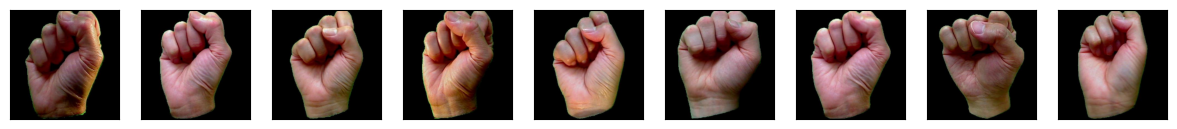

In [10]:
# visulization

fig = plt.figure(figsize=(20,5))
for i in range(9):
  ax = fig.add_subplot(3,12,1+i,xticks=[],yticks=[])
  ax.imshow(np.squeeze(data[i]))

In [ ]:
print('The number of class for this problem is:',len(np.unique(label)))

The number of class for this problem is: 36


### Data Preprocessing

- Splitting the data into train,test and validation sets

In [11]:
x_train,x_test,y_train,y_test = train_test_split(
    data,
    label,
    test_size = 0.2,
    random_state = 42
)

x_train,x_val,y_train,y_val = train_test_split(
    x_train,
    y_train,
    test_size = 0.2,
    random_state = 42
)

In [12]:
print('validation shape:',x_val.shape)
print('validation labels shape:',y_val.shape)
print('test shape:',x_test.shape)
print('test labels shape:',y_test.shape)
print('train shape',x_train.shape)
print('train labels shape:',y_train.shape)

validation shape: (403, 224, 224, 3)
validation labels shape: (403,)
test shape: (503, 224, 224, 3)
test labels shape: (503,)
train shape (1609, 224, 224, 3)
train labels shape: (1609,)


In [ ]:
y_train[:5]

array(['0', 'o', 'v', '5', 'j'], dtype='<U1')

In [13]:
# normalization

x_train = x_train/255.0
x_test = x_test/255.0
x_val = x_val/255.0

- When given <U1 as the data type of the labels , it means it is a unicode string of length 1

In [14]:
# encode string to integers

le = preprocessing.LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)
y_val_encoded = le.fit_transform(y_val)

## Modelling using a pretrained model VGG16

---



In [ ]:
base_model = vgg16.VGG16(weights = 'imagenet',include_top = False,
                         input_shape = (224,224,3),
                         pooling='avg')

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
# we will train the last 5 layers of the model
for layer in base_model.layers[:-5]:
  layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

- Adding a new classifier

In [ ]:
last_output = base_model.output

x = tf.keras.layers.Dense(36,activation = 'softmax',name = 'softmax')(last_output)
new_model = tf.keras.Model(inputs = base_model.input,outputs=x)

new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Compiling

In [ ]:
# learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.0001,
    decay_steps = 1000,
    decay_rate = 0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
# compiling the model
new_model.compile(optimizer = optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics = ['accuracy'])

from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath ='signlanguage.model.hdf5',save_best_only=True)

history = new_model.fit(x_train,y_train_encoded,
                        validation_data= (x_val,y_val_encoded),
                        epochs = 32,batch_size=32,verbose=1,callbacks= [checkpointer])

Epoch 1/32
51/51 [==============================] - ETA: 0s - loss: 2.4205 - accuracy: 0.3567

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 26s 331ms/step - loss: 2.4205 - accuracy: 0.3567 - val_loss: 1.0215 - val_accuracy: 0.7122
Epoch 2/32
51/51 [==============================] - 10s 192ms/step - loss: 0.5787 - accuracy: 0.8210 - val_loss: 0.3103 - val_accuracy: 0.9082
Epoch 3/32
51/51 [==============================] - 10s 195ms/step - loss: 0.2575 - accuracy: 0.9316 - val_loss: 0.2152 - val_accuracy: 0.9305
Epoch 4/32
51/51 [==============================] - 10s 198ms/step - loss: 0.1762 - accuracy: 0.9441 - val_loss: 0.1458 - val_accuracy: 0.9553
Epoch 5/32
51/51 [==============================] - 9s 173ms/step - loss: 0.1008 - accuracy: 0.9695 - val_loss: 0.1736 - val_accuracy: 0.9628
Epoch 6/32
51/51 [==============================] - 9s 179ms/step - loss: 0.0954 - accuracy: 0.9677 - val_loss: 0.1142 - val_accuracy: 0.9603
Epoch 7/32
51/51 [==============================] - 10s 201ms/step - loss: 0.0905 - accuracy: 0.9677 - val_loss: 0.1060 - val_accuracy: 0.9677
Epoch 8/32
5

## Model Evaluation

In [ ]:
loss,accuracy = new_model.evaluate(x_test,y_test_encoded)
print('Test test accuracy:',accuracy)

16/16 [==============================] - 7s 463ms/step - loss: 0.0674 - accuracy: 0.9841
Test test accuracy: 0.9840954542160034


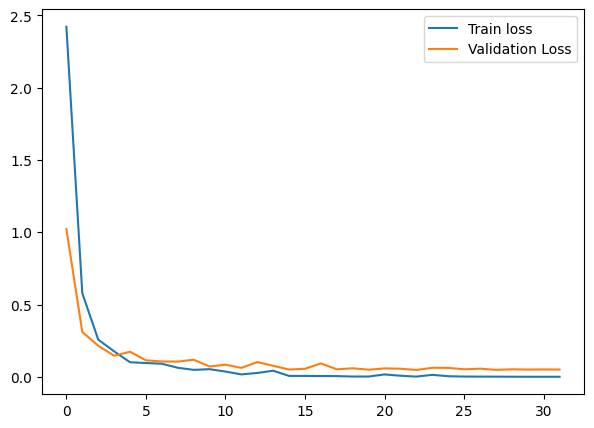

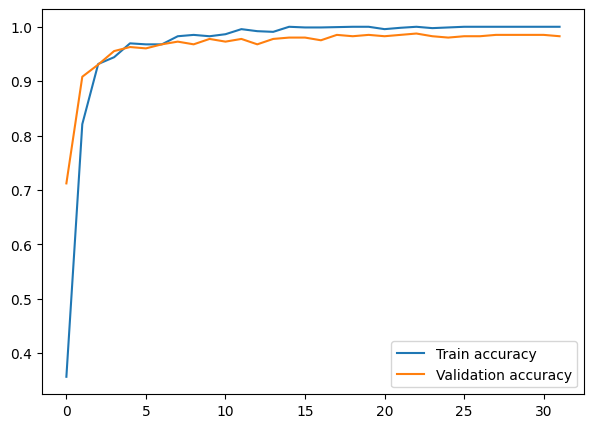

In [ ]:
# plot Training and validation loss over each of the epochs

plt.figure(figsize=(7,5))
plt.plot(history.history['loss'],label='Train loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.legend()

# plot the training and the validation accuracy over each epoch

plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'],label='Train accuracy')
plt.plot(history.history['val_accuracy'],label='Validation accuracy')
plt.legend()


### Classification report

In [ ]:
y_pred = new_model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)

print(classification_report(y_pred,y_test_encoded))

16/16 [==============================] - 2s 129ms/step
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       1.00      1.00      1.00        13
           2       1.00      0.94      0.97        16
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        25
           6       0.90      1.00      0.95         9
           7       1.00      1.00      1.00        14
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        16
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00         9
          13       1.00      0.88      0.94        17
          14       1.00      1.00      1.00        14
          15       1.00      1.00      1.00        10
          16       1.00   

### Confusion matrix

Text(0.5, 1.0, 'Confusion Matrix')

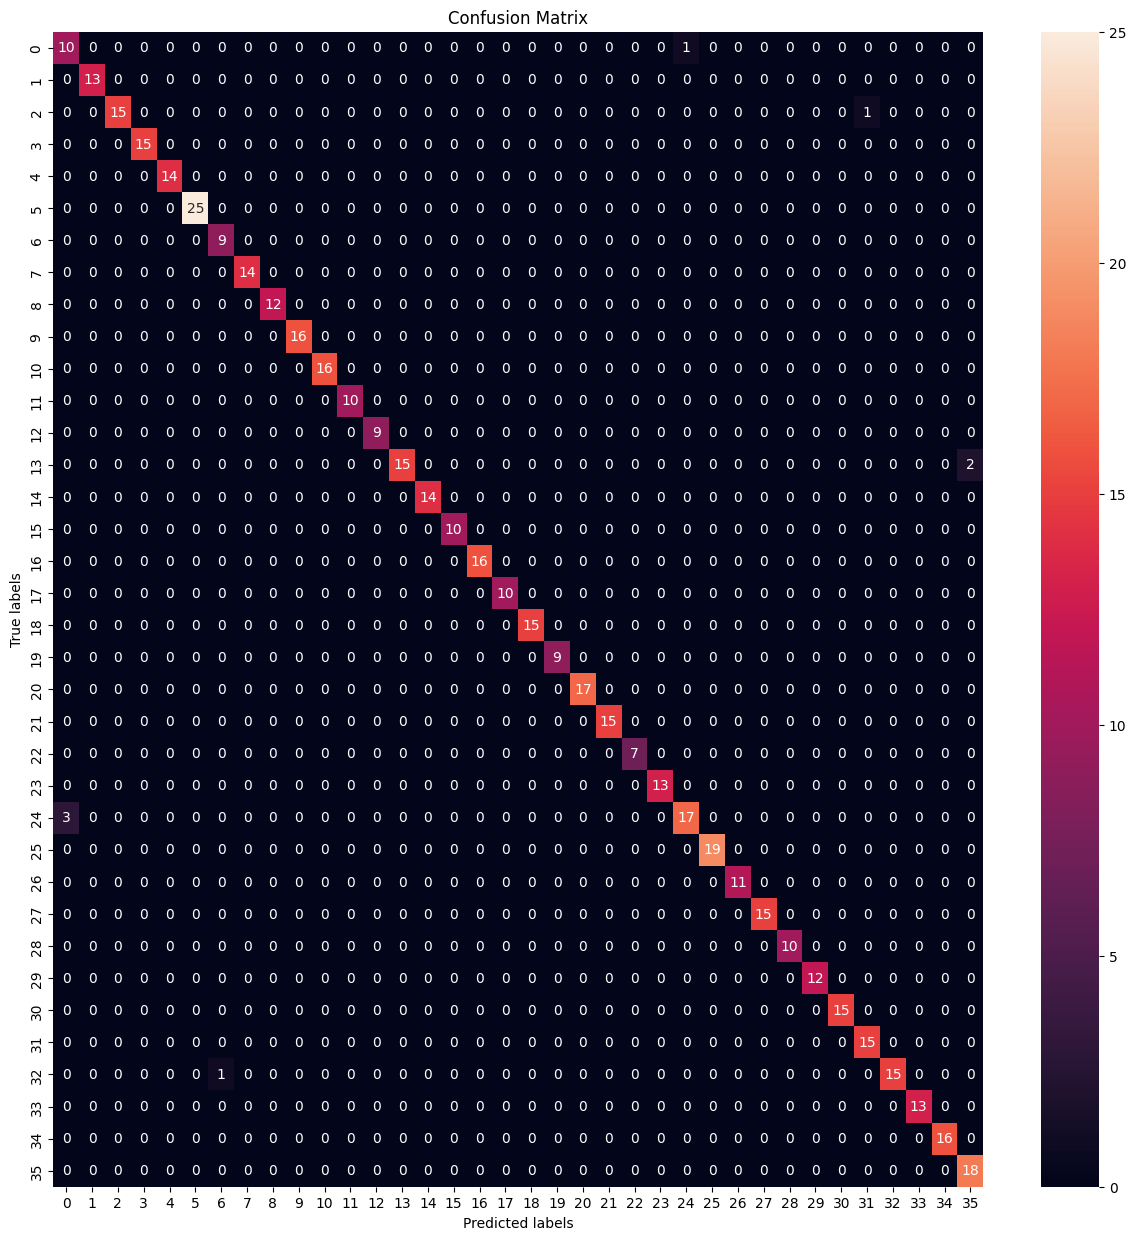

In [ ]:
cm=confusion_matrix(y_pred,y_test_encoded)
fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm,annot=True,fmt='g',ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix')

In [ ]:
## save the model

new_model.save('SignLanguage_v1.h5')



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
# incase you want to load the model
mod = tf.keras.models.load_model('SignLanguage_v1.h5')

In [ ]:
#from google.colab import files

# Download the saved model file
#files.download('SignLanguage_v1.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Interactive session

In [29]:
!pip install gradio --upgrade

import gradio as gr

: 

In [18]:
labels = np.unique(y_train)
labels

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c',
       'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
       'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1')

In [25]:
def predict_input_image(img):
  image = img.reshape(-1,224,224,3)
  prediction = mod.predict(image)[0]
  confidences = {label[i]:float(prediction[i]) for i in range(36)}
  return confidences



In [28]:
import gradio as gr
inputs = gr.inputs.Image(shape=(224,224))
outputs = gr.outputs.Label(num_top_classes=3)
gr.Interface(predict_input_image,inputs,outputs,
             interpretation='default',title='Sign Language Classification',
             examples=['/media/danlof/dan files/data_science_codes/sign_language_project/asl_dataset/hand1_h_left_seg_5_cropped.jpeg',
                       '/media/danlof/dan files/data_science_codes/sign_language_project/asl_dataset/hand2_7_dif_seg_2_cropped.jpeg']).launch(debug=True)

AttributeError: module 'gradio' has no attribute 'inputs'